#HW 10 CLUSTERING BUSINESS

#cluster time trends in NYC businesses: 
#DATA
#Census Business data:
##download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


#NYC zip codes shape file is here
##http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [800]:
import pandas as pd
import numpy as np
import zipfile 
import pandas as pd
import glob
import urllib2
import json
import pylab as pl
import sklearn.cluster
import os
import scipy 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [801]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

### Part 1: Data Prep and Cleaning

In [802]:
#Read zip files and create a dictionary contains all the data.
df={}
for i in range (94,100):
    fname = 'zbp{0}totals.zip'.format(i)
    zf = zipfile.ZipFile(fname)
    df[i] = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
        
    for i in range (0,10):
        fname = 'zbp0{0}totals.zip'.format(i)
        zf = zipfile.ZipFile(fname)
        df[i] = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
                
    for i in range (10,14):
        fname = 'zbp{0}totals.zip'.format(i)
        zf = zipfile.ZipFile(fname)
        df[i] = pd.read_csv(zf.open(fname.replace('.zip','.txt')))        
    

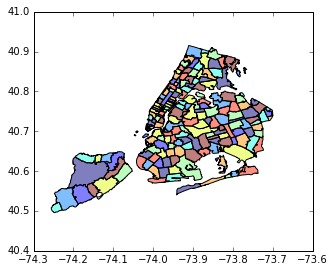

In [803]:
import geopandas as gp
fname = 'nyc-zip-code-tabulation-areas-polygons.geojson'
nyc = gpd.read_file(fname)
nyc.plot(figsize=(5,5))

In [804]:
#Make an index of the years as a list:
index = df.keys()
#Convert columns name to all lower cases:
for i in index: # index is the list of years
    a = [x.lower() for x in (df[i].columns.tolist())]
    df[i].columns = a
#df

In [805]:
df1 = {}
for i in index:
    df1[i] = df[i][['zip', 'est']]
    df1[i]['year'] = i
#df1

/Users/ericlaibuffalo/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [806]:
for i in index:
    print df1[i].shape

(39853, 3)
(39817, 3)
(39451, 3)
(39423, 3)
(39583, 3)
(39625, 3)
(39657, 3)
(39652, 3)
(39240, 3)
(39174, 3)
(39104, 3)
(39032, 3)
(38818, 3)
(38804, 3)
(40099, 3)
(39761, 3)
(40248, 3)
(39467, 3)
(39259, 3)
(39932, 3)


In [807]:
d0 = pd.DataFrame(df1[0])

for i in index[1:]:
    d3 = pd.DataFrame(df1[i])
    d0 = np.concatenate((d0, d3), axis=0)
data = pd.DataFrame(d0, columns = ['zip','est','year'])
print data.shape
print data.columns

(789999, 3)
Index([u'zip', u'est', u'year'], dtype='object')


In [808]:
url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
request = urllib2.urlopen(url)
nyc_zipcodes = json.load(request)
nyc_zip = []
for department in nyc_zipcodes['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))
print nyc_zip

['11372', '11004', '11040', '11426', '11365', '11373', '11001', '11375', '11427', '11374', '11366', '11423', '11428', '11432', '11379', '11429', '11435', '11415', '11418', '11433', '11451', '11221', '11421', '11419', '11434', '11216', '11416', '11233', '11436', '11213', '11212', '11225', '11218', '11226', '11219', '11210', '11230', '11204', '10471', '10470', '10466', '10467', '10463', '10475', '10464', '10469', '10468', '10463', '10458', '10034', '10033', '10462', '10040', '10453', '10465', '10464', '10464', '10461', '10457', '10460', '10032', '10452', '10456', '10472', '10031', '10039', '10459', '10451', '10473', '10030', '10027', '10474', '10455', '10037', '10024', '10454', '10026', '10035', '10025', '10035', '11357', '10029', '00083', '11356', '11359', '11360', '11105', '10128', '11371', '10023', '11363', '10028', '11354', '11102', '11370', '10021', '11361', '11358', '11362', '10044', '11369', '11103', '11106', '11368', '11377', '10036', '11355', '11101', '11364', '10018', '10020', 

In [809]:
data['zip'] = data['zip'].astype(str)
table = data['zip'].isin(nyc_zip)
data = data[table]
data.head()

,zip,est,year
3010,10001,7317,0
3011,10002,2277,0
3012,10003,3683,0
3013,10004,1294,0
3014,10005,1287,0


In [810]:
#create the indeces array here
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False  
indx1 = np.vectorize(canconvert)(data['est'])
data['est'][~indx1]=float('NaN')

In [811]:
group = data.groupby(['year','zip']).mean().unstack()
group.head()

est                                                        ...         \
zip  10001 10002 10003 10004 10005 10006 10007 10009 10010 10011  ...  11433   
year                                                              ...          
0     7317  2277  3683  1294  1287  1067  1327   860  3203  3653  ...    266   
1     7188  2543  3602  1247  1249  1026  1233   869  3178  3592  ...    269   
2     7141  2269  3616  1253  1244   934  1620   921  3085  3682  ...    293   
3     7084  2402  3704  1252  1200   862  1603   953  3045  3711  ...    289   
4     7370  2551  3776  1283  1226   869  1635   982  3059  3729  ...    292   

                                                            
zip  11434 11435 11436 11451 11691 11692 11693 11694 11697  
year                                                        
0      825   653    65     4   376    79    79   288    39  
1      853   656    57     5   394    71    89   301    40  
2      863   688    78     5   409    75    94   302    37  
3      861   716    74     5   426    74    98   302    43  
4      869   728    84     5   436    68    96   303    43  

[5 rows x 244 columns]

In [812]:
final = group['est']
final.to_csv('final.csv')
final = pd.read_csv('final.csv')
#Define the list of years:
year = np.arange(1994, 2014, 1).tolist()
#final.index = year
#final = final.transpose()
final['year'] = ['2000','2001','2002','2003','2004','2005','2006','2007',
                 '2008','2009','2010', '2011','2012','2013','1994','1995','1996','1997','1998','1999']
final.index = final['year']
del final['year']

final=final.sort_index()
final.to_csv('final.csv')
final.head()

,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,...,11433,11434,11435,11436,11451,11691,11692,11693,11694,11697
year,,,,,,,,,,,,,,,,,,,,,
1994,6999,1784,3256,1115,1076,1061,1307,634,3019,3301,...,226,760,586,51,2,401,66,95,294,33
1995,7088,1819,3377,1124,1109,1002,1274,633,2987,3340,...,240,768,598,50,2,394,67,90,285,32
1996,7075,1919,3417,1133,1216,969,1254,673,3029,3392,...,241,777,596,53,2,406,71,88,287,34
1997,7154,2049,3535,1173,1227,990,1287,747,3112,3541,...,252,817,599,51,3,399,73,83,294,38
1998,7254,2003,3649,1176,1270,1030,1282,786,3152,3599,...,269,800,634,51,3,387,69,79,291,38


In [813]:
final = pd.read_csv('final.csv')
final.index = final['year'].values
del final['year']
final = final.transpose()

In [814]:
#col = final.columns.values.tolist()
for n in range(0,len(final)):
    final.iloc[n] = (final.iloc[n]-final.iloc[n].mean())/final.iloc[n].std()

final.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
10001,-1.785254,-1.143543,-1.237276,-0.667668,0.053356,-0.098059,0.507600,-0.422520,-0.761401,-1.172384,0.889743,0.471549,1.214203,2.180374,1.625186,0.421078,-0.040377,-0.141321,-0.083639,0.190350
10002,-1.679191,-1.590586,-1.337429,-1.008325,-1.124777,-0.917188,-0.431127,0.242271,-0.451379,-0.114680,0.262524,0.594160,0.604286,0.601754,0.616944,0.829596,1.075158,1.176421,1.282747,1.368820
10003,-1.825115,-1.420351,-1.286545,-0.891817,-0.510470,-0.477019,-0.396735,-0.667692,-0.620860,-0.326487,-0.085636,0.218773,0.359269,0.827590,0.901184,0.994848,1.041680,1.195557,1.379540,1.590285
10004,-1.568159,-1.485188,-1.402216,-1.033455,-1.005797,-0.480312,0.082049,-0.351245,-0.295931,-0.305150,-0.019360,-0.231398,0.238773,0.782697,0.838011,0.865668,1.040830,1.096144,1.446468,1.787572
10005,-2.812883,-2.245666,-0.406506,-0.217433,0.521668,0.040393,0.813871,0.160712,0.074770,-0.681520,-0.234622,-0.440883,0.332596,0.573233,0.882625,0.590422,0.452915,1.054509,0.573233,0.968567


In [815]:
final.dropna()
final.shape

(244, 20)

In [816]:
final.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
10001,-1.785254,-1.143543,-1.237276,-0.667668,0.053356,-0.098059,0.507600,-0.422520,-0.761401,-1.172384,0.889743,0.471549,1.214203,2.180374,1.625186,0.421078,-0.040377,-0.141321,-0.083639,0.190350
10002,-1.679191,-1.590586,-1.337429,-1.008325,-1.124777,-0.917188,-0.431127,0.242271,-0.451379,-0.114680,0.262524,0.594160,0.604286,0.601754,0.616944,0.829596,1.075158,1.176421,1.282747,1.368820
10003,-1.825115,-1.420351,-1.286545,-0.891817,-0.510470,-0.477019,-0.396735,-0.667692,-0.620860,-0.326487,-0.085636,0.218773,0.359269,0.827590,0.901184,0.994848,1.041680,1.195557,1.379540,1.590285
10004,-1.568159,-1.485188,-1.402216,-1.033455,-1.005797,-0.480312,0.082049,-0.351245,-0.295931,-0.305150,-0.019360,-0.231398,0.238773,0.782697,0.838011,0.865668,1.040830,1.096144,1.446468,1.787572
10005,-2.812883,-2.245666,-0.406506,-0.217433,0.521668,0.040393,0.813871,0.160712,0.074770,-0.681520,-0.234622,-0.440883,0.332596,0.573233,0.882625,0.590422,0.452915,1.054509,0.573233,0.968567


In [817]:
final =final.dropna()

zipcode = final.index.tolist()
final.shape

(230, 20)

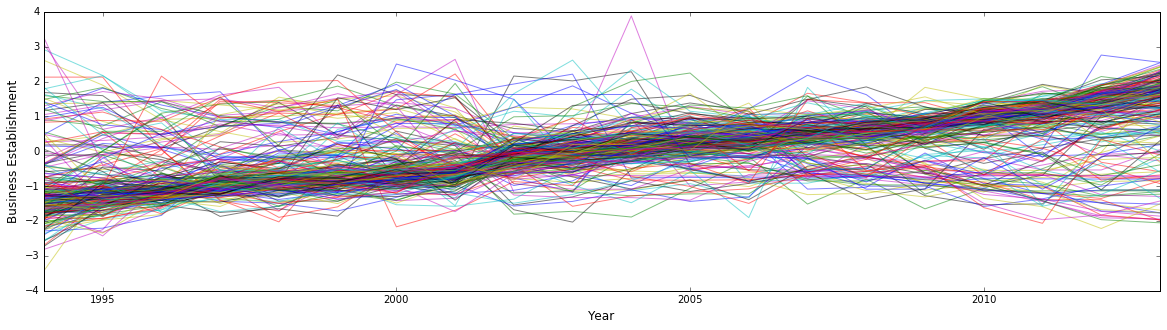

In [818]:
pl.figure(figsize=(20,5))
plt.xlim(1994,2013)

for i in range(len(final)):
    plt.plot(final.iloc[i],alpha=0.5)
    
pl.ylabel("Business Establishment", fontsize=12)
pl.xlabel("Year", fontsize=12)

### K-Means Clustering (2, 3, 5 Clusters):

In [819]:
x = final.values

def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

import random
def k_means_clust(data,num_clust,num_iter):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print counter
        assignments={}
        
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if euclid_dist(i,j)<min_dist:
                    min_dist = euclid_dist(i,j)
                    closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    return centroids

In [820]:
x = final.values
centroids=k_means_clust(x,2,10)
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

1
2
3
4
5
6
7
8
9
10


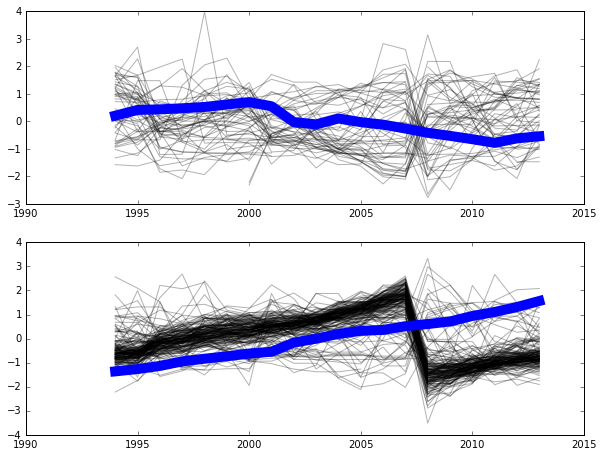

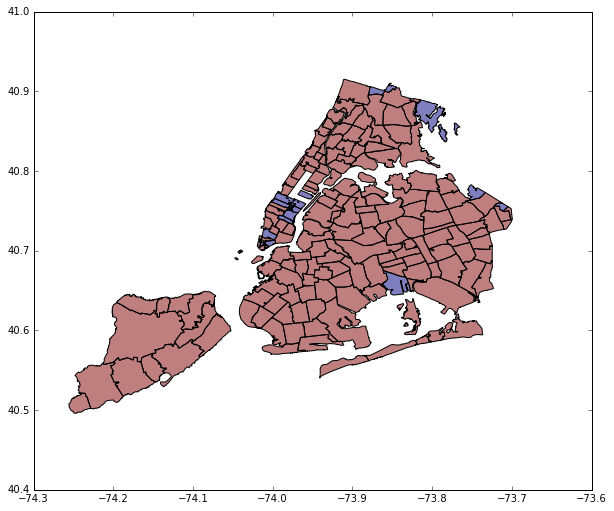

In [821]:
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
cluster = cluster.sort_index()
mydata = pd.DataFrame({'zip':zipcode,
                       'cluster':cluster})
zips = str(mydata.iloc[i]['zip'])
cluster = mydata.iloc[i]['cluster']

fig = plt.figure(figsize=(10,20))
ax = []
for i in range(len(centroids)):
    ax.append(fig.add_subplot(5,1,i+1)) 
for i in range(len(mydata)):
    cluster = mydata.iloc[i]['cluster']
    ax[cluster].plot(result.iloc[i],'k',alpha=0.3)
for i in range(len(centroids)):    
    ax[i].plot(year,centroids[i],linewidth=10)


map_data = pd.merge(nyc, mydata, left_on = 'postalCode', right_on = 'zip')
map_data.plot(column='cluster', figsize=(10,10))

In [822]:
x = final.values
centroids=k_means_clust(x,3,10)
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

1
2
3
4
5
6
7
8
9
10


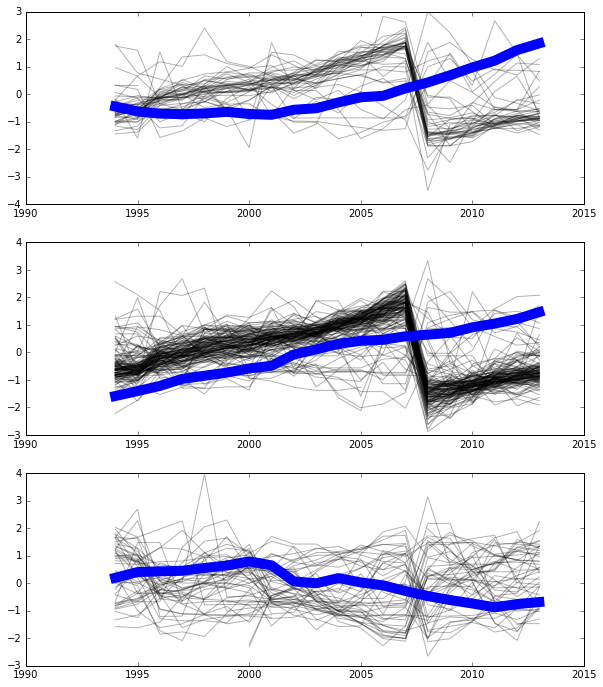

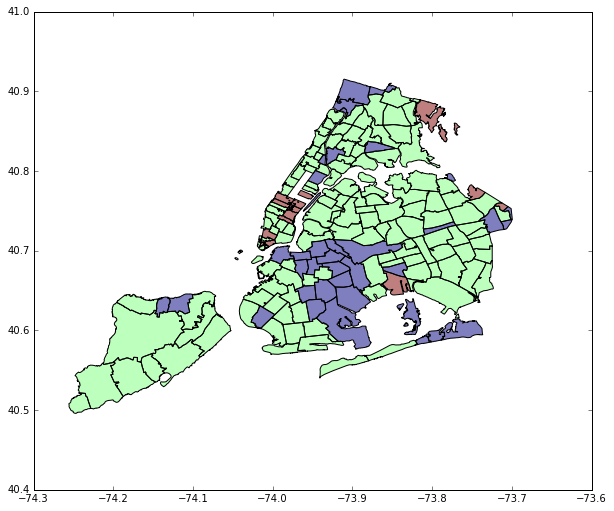

In [823]:
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
cluster = cluster.sort_index()
mydata = pd.DataFrame({'zip':zipcode,
                       'cluster':cluster})
zips = str(mydata.iloc[i]['zip'])
cluster = mydata.iloc[i]['cluster']

fig = plt.figure(figsize=(10,20))
ax = []
for i in range(len(centroids)):
    ax.append(fig.add_subplot(5,1,i+1)) 
for i in range(len(mydata)):
    cluster = mydata.iloc[i]['cluster']
    ax[cluster].plot(result.iloc[i],'k',alpha=0.3)
for i in range(len(centroids)):    
    ax[i].plot(year,centroids[i],linewidth=10)
    
map_data = pd.merge(nyc, mydata, left_on = 'postalCode', right_on = 'zip')
map_data.plot(column='cluster', figsize=(10,10))

In [824]:
x = final.values
centroids=k_means_clust(x,5,10)
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

1
2
3
4
5
6
7
8
9
10


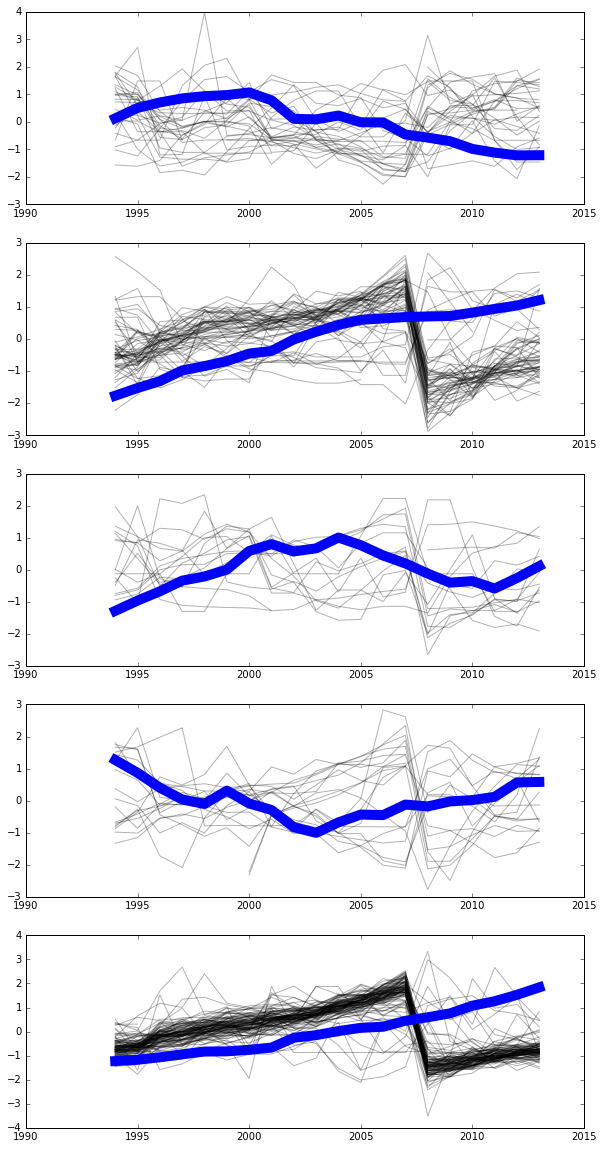

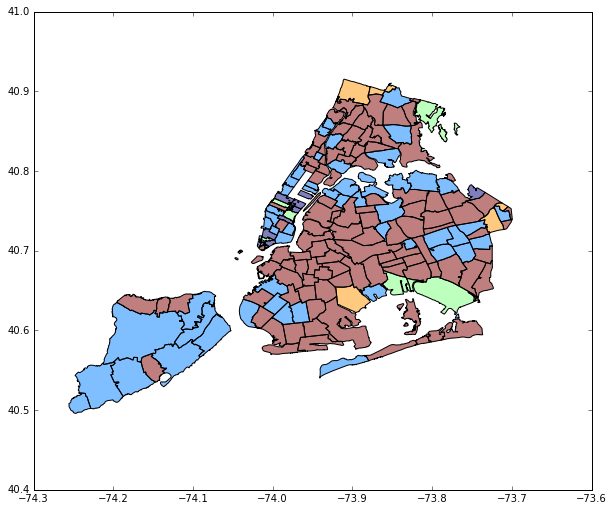

In [825]:
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
cluster = cluster.sort_index()
mydata = pd.DataFrame({'zip':zipcode,
                       'cluster':cluster})
zips = str(mydata.iloc[i]['zip'])
cluster = mydata.iloc[i]['cluster']

fig = plt.figure(figsize=(10,20))
ax = []
for i in range(len(centroids)):
    ax.append(fig.add_subplot(5,1,i+1)) 
for i in range(len(mydata)):
    cluster = mydata.iloc[i]['cluster']
    ax[cluster].plot(result.iloc[i],'k',alpha=0.3)
for i in range(len(centroids)):    
    ax[i].plot(year,centroids[i],linewidth=10)

map_data = pd.merge(nyc, mydata, left_on = 'postalCode', right_on = 'zip')
map_data.plot(column='cluster', figsize=(10,10))

### DBScan Cluster:
This is another clustering algorithm I used. 

I think K-means performs better thanks DBScan Cluster.



In [826]:
# Calculate distance matrix
dist_mat = pd.DataFrame(np.zeros(shape=(len(final),len(final))))
for i in range(len(final)):
    for j in range(len(final)):
        dist_mat.iloc[i][j] = euclid_dist(final.iloc[i],final.iloc[j])

In [827]:
from sklearn.cluster import DBSCAN
db = DBSCAN(metric="precomputed",eps=2).fit(dist_mat)

In [828]:
labels = (db.labels_).astype(int)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: %d' % num_clusters)

Number of clusters: 3


In [829]:
cluster = db.labels_+2
nyczip = final.index.tolist()
mydata = pd.DataFrame({'zip':nyczip,
                       'cluster':cluster})
mydata.head()

,cluster,zip
0,1,10001
1,2,10002
2,2,10003
3,2,10004
4,1,10005


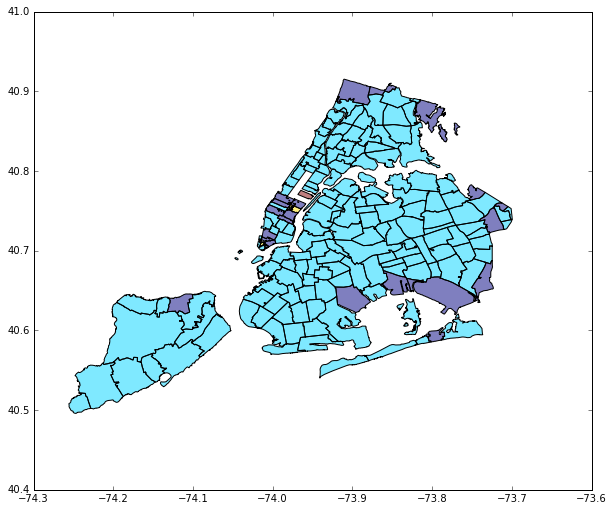

In [830]:
map_data = pd.merge(nyc, mydata, left_on = 'postalCode', right_on = 'zip')
map_data.plot(column='cluster', figsize=(10,10))

### Dynamic Time Warping: K-means Clustering
This is another possible code I was working on, and I think this one would performs better than the one only measures 
__Euclidean Distance__ of time series data. However I'm still working on this method and trying to get the code to work.

In [ ]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1.iloc[i]-s2.iloc[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [ ]:
for i in range (0, len(final)-1):
    m=i+1
    print DTWDistance(final.iloc[i],final.iloc[m],10)

In [ ]:
import random

def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return sqrt(LB_sum)

In [ ]:
for i in range (0, len(final)-1):
    m=i+1
    print LB_Keogh(final.iloc[i],final.iloc[m],10)

In [ ]:
def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
        
        else:
                assignments[closest_clust]=[]

        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                centroids[key]=[m/len(assignments[key]) for m in clust_sum]

    return centroids

In [ ]:
centroids=k_means_clust(final,3,5,5)
for i in centroids:

    plt.plot(i)

plt.show()

###Cluster Interpretation:
Based on clustering, we noticed that the spatial difference in business growth by zip code in NYC. Especially, it indecates that through 2004 to 2013, Mid-town Manhattan went through a quite slow growth in new business establishment. We can see this phenomena through all clustering by 2, 3, 5 K-means clusters. It also shows there is a slow growth in West Brooklyn.

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    